## Note

This script contains the primary step of trying different machine learning algorithm to answer the question: Whether we can detect a speech audio file contains filler words or not.

In order to run this script:

    1. all .wav file should be already processed into .csv file through proj2.ipynb
    2. This script should be in the same folder with all .csv files listed in 'filename' list 
    
The algorithms are performed based on the following assumptions:
    
    1. The wave data (after PDA step) is compressed to a list of 20x4 matrix. 20 rows is chosen by the MFCC normalize algorithm and 4 features is chosen as the component number at PDA step. These two parameters can be modified.
    
    2. The 20x4 matrix is flattened (reshape) to a 80-element list. Data X is a 203 rows of a single column containing a list of 80 element.

In [3]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
import pandas as pd
import re
%matplotlib inline

### Re-create the data into dataframe

In [4]:
filename = ['astronomy_filler','batman_filler','food_filler','forrestgump_filler','greeneggs_filler',
           'hamlet_filler','honorcode_filler','ironman_filler','uh_training','wonka_filler']

In [5]:
def genDataFrame(names,masterDF):
    for file in names:
        df = pd.read_csv(file+'.csv')
        masterDF = pd.concat([masterDF,df])
    #reset indices
    masterDF = masterDF.reset_index(drop=True)
    return masterDF
masterOrig = genDataFrame(filename,pd.DataFrame())
masterOrig.head()
#Change column name 
masterOrig = masterOrig.rename(columns={'Featured Wave': 'Wave'})

In [10]:
#Since the value at column "Wave" is string type when converting .csv files to dataframe
#convertString2Array(df,col_name) will convert "Wave" column's values from string back to np.array
import re, ast
def convertString2Array(df,col_name):
    numRows = df.shape[0]
    new_values = []
    #for each row in the given column
    for r in range(numRows):
        #get the original value of cell
        cell = df[col_name].values[r]#df[col_name][r].values[0]
        #convert string to np array
        cell = re.sub("\s+",",",cell)
        cell = cell.replace("[,","[")
        new_cell = np.array(ast.literal_eval(cell))
        #add to a new list
        new_values.append(new_cell)
    #Modify the given column to new values
    df[col_name] = new_values
    return df
masterOrig = convertString2Array(masterOrig,'Wave')

In [12]:
#Since the data is 203 x 20 x 4 (203 matrices of shape 20x4)
#convertSeries2X(df,seriesName)flatten out the matrix and convert 
#203x20x4 to 203x80
def convertSeries2X(df,seriesName):
    new_X = []
    for element in df[seriesName].values:
        new_X.append(element.flatten())
    new_X = np.array(new_X)
    return new_X

In [13]:
X = convertSeries2X(masterOrig,'Wave')
X.shape

(203, 80)

# Algorithms

Features of the algorithms will be the PCA-ed wave arrays in column 'Wave' and Target will be column 'is Filler'
In order to have the right format to be train, feature data will need to be decrea

## Clustering Algorithms

In [82]:
#===PREPARING METHODS TO VALIDATE UNSUPERVISED LEARNING====#
from scipy import stats
def fromIdx2String(num):
    if num == 0:
        return 'Normal record'
    else:
        return 'Filler record'
def cluster2Filler(data,target,clusters,clusterID):
    report = ''
    size = len(clusters)
    #Identify which number this cluster mostly represent - cluster_rep
    clusterIdx = [i for i in range(size) if clusters[i] == clusterID]
    true_targets = target[clusterIdx] #true target of the components in this cluster
    cluster_rep = stats.mode(true_targets)[0][0] #most common target is the representative of this cluster

    #Calculate the frequency of cluster_rep in this cluster
    rep_cluster_count = sum(target[clusterIdx] == cluster_rep)
#     print('* ' + str(rep_cluster_count))
    
    #Calculate the frequency of cluster_rep in the whole data
    rep_data_count = sum([ (target[i] == cluster_rep) for i in range(size)])
#     print('* ' + str(rep_data_count))

    #True positive 
    TP = round(rep_cluster_count / rep_data_count * 100,2)
    report += 'Cluster ' + str(clusterID) + ' is mostly ' + fromIdx2String(cluster_rep) + ' ( ' + str(TP) + '% TP); '
    
    #False negatives
    report += ' ' + fromIdx2String(cluster_rep) + ' is also in clusters '
    
    #Search in other clusters for the representative
    for ID in range(2):
        if (ID != clusterID):
            #Identify this cluster id list
            otherClusterIdx = [i for i in range(size) if clusters[i] == ID]
            other_true_targets = target[otherClusterIdx]
            #Check if this cluster contains the representative 
            containsRep = cluster_rep in np.unique(other_true_targets)
            #If, contain rep, do some works
            if containsRep == True:
                #Calculate frequency of rep in this cluster 
                rep_frequency = sum(other_true_targets == cluster_rep)
                
                #Rep % 
                rep_percentage = round(rep_frequency / rep_data_count * 100,2)
                
                #Update report 
                report += str(ID) + '(' + str(rep_percentage) + '%) '   
    print (report)

In [83]:
# from sklearn.cluster import KMeans
# plt.scatter(X[:, 0], X[:, 70], s=50, cmap='viridis') #Dropping the outliners
# plt.show()

### 1. KMeans

In [84]:
#Create a new copy of original master
masterKM = masterOrig.copy()

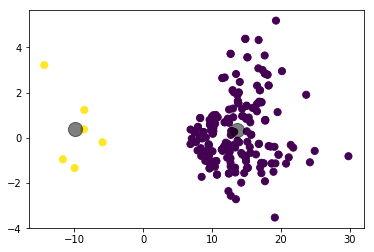

In [199]:
kmeans = KMeans(n_clusters=2)
X = convertSeries2X(masterKM,'Wave')
kmeans.fit(X)
Yhat = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=Yhat,s=50, cmap='viridis') #Confirm dropping the yellow outliers 
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()  

In [87]:
print('Result of testing on training data:')
cluster2Filler(X,masterKM['is Filler'].values,Yhat,0)
cluster2Filler(X,masterKM['is Filler'].values,Yhat,1)

Result of testing on training data:
Cluster 0 is mostly Normal record ( 96.88% TP);  Normal record is also in clusters 1(3.12%) 
Cluster 1 is mostly Normal record ( 3.12% TP);  Normal record is also in clusters 0(96.88%) 


Comment: Both clusters contain a high number of 'non-filler' waves. Clearly, 'is-filler' waves is not fully separated. However, we're curious on what information the yellow outliers contain

In [89]:
outlier_idx = [idx for idx in range(len(Yhat)) if Yhat[idx] == 1]
#Check the outlier's information
masterKM.iloc[outlier_idx]

,Original File,Chunk Number,Wave,is Filler
30,food_filler.wav,15,"[[-9.95699732, -1.33989126, -0.923800407, 0.27...",0
124,honorcode_filler.wav,24,"[[-8.59750934, 0.37149731, -0.833329412, -0.05...",0
127,honorcode_filler.wav,4,"[[-5.90168716, -0.197360213, 0.189155613, 0.00...",0
188,uh_training.wav,7,"[[-11.66462645, -0.95131845, 0.07867855, -0.04...",1
196,wonka_filler.wav,3,"[[-8.55833352, 1.22972748, -0.178484, -0.09501...",0
201,wonka_filler.wav,8,"[[-14.3743407, 3.21389045, 0.104736432, 0.1675...",0


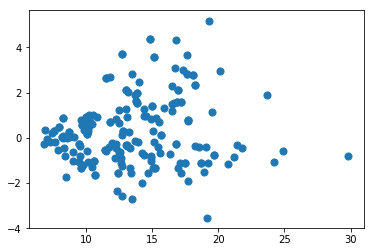

In [90]:
#Drop the outlier
masterKM_clean = masterKM.drop(masterKM.index[outlier_idx])
masterKM_clean = masterKM_clean.reset_index()

X_clean = convertSeries2X(masterKM_clean,'Wave')
plt.scatter(X_clean[:, 0], X_clean[:,1], s=50, cmap='viridis')
plt.show() 

In [91]:
X_clean.shape

(197, 80)

### 2. Spectral Clustering

In [158]:
from sklearn.cluster import SpectralClustering
#Create a new copy of original master
master= masterOrig.copy()
X = convertSeries2X(master,'Wave')
y = master['is Filler'].values

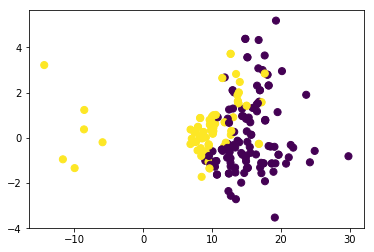

In [153]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [159]:
print('Spectral Clustering result:')
cluster2Filler(X,y,labels,0)
cluster2Filler(X,y,labels,1)

Spectral Clustering result:
Cluster 0 is mostly Normal record ( 48.12% TP);  Normal record is also in clusters 1(51.88%) 
Cluster 1 is mostly Normal record ( 51.88% TP);  Normal record is also in clusters 0(48.12%) 


Again, the clustering still detects both cluster as 'non-filler' cluster. However, this time, the algorithm seems to be worst since there is a nearly even split of Normal records in both cluster. Let's try this algorithm again with the non-outlier data:

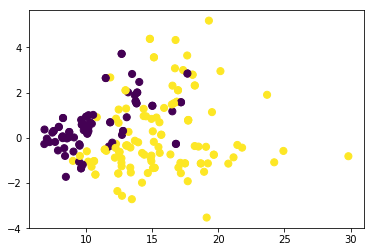

In [155]:
model_clean = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',assign_labels='kmeans')
labels_clean = model_clean.fit_predict(X_clean)
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=labels_clean, s=50, cmap='viridis');

In [160]:
# cluster2Filler(masterKM_clean['is Filler'],labels_clean,2)
print('Spectral Clustering result without the outliers:')
y_clean = masterKM_clean['is Filler'].values
cluster2Filler(X,y_clean,labels_clean,0)
cluster2Filler(X,y_clean,labels_clean,1)

Spectral Clustering result without the outliers:
Cluster 0 is mostly Normal record ( 52.26% TP);  Normal record is also in clusters 1(47.74%) 
Cluster 1 is mostly Normal record ( 47.74% TP);  Normal record is also in clusters 0(52.26%) 


Sprectral Clustering on clean X is no better.

### 3. Mini Batch Kmeans

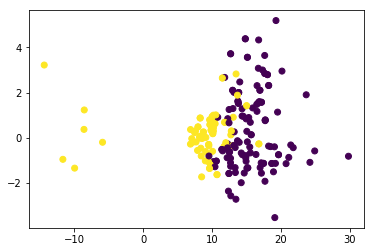

In [157]:
from sklearn import cluster, mixture
mb= cluster.MiniBatchKMeans(2)
mb_result=mb.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],  c=mb_result)
plt.show()  

In [161]:
# cluster2Filler(masterMB['is Filler'],mb_result,2)
print('Mini batch Kmeans result:')
cluster2Filler(X,master['is Filler'].values,mb_result,0)
cluster2Filler(X,master['is Filler'].values,mb_result,1)

Mini batch Kmeans result:
Cluster 0 is mostly Normal record ( 51.88% TP);  Normal record is also in clusters 1(48.12%) 
Cluster 1 is mostly Normal record ( 48.12% TP);  Normal record is also in clusters 0(51.88%) 


Comment: not going to move on with MiniBatch KMeans

### 5. Birch

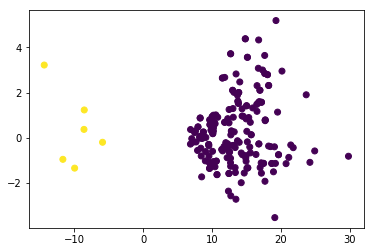

Birch Clustering result:
Cluster 0 is mostly Normal record ( 96.88% TP);  Normal record is also in clusters 1(3.12%) 
Cluster 1 is mostly Normal record ( 3.12% TP);  Normal record is also in clusters 0(96.88%) 


In [162]:
#Birch

bi=cluster.Birch(n_clusters=2)
bi_result=bi.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],  c=bi_result)
plt.show()  

print('Birch Clustering result:')
cluster2Filler(X,y,bi_result,0)
cluster2Filler(X,y,bi_result,1)

### 5. Gaussian Mixture Clustering

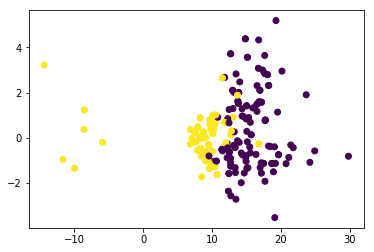

Gaussian Mixture Clustering result:
Cluster 0 is mostly Normal record ( 53.12% TP);  Normal record is also in clusters 1(46.88%) 
Cluster 1 is mostly Normal record ( 46.88% TP);  Normal record is also in clusters 0(53.12%) 


In [164]:
#Gaussian Mixture

gm=mixture.GaussianMixture(n_components=2,covariance_type='full')
gm.fit(X)
gm_result=gm.predict(X)

plt.scatter(X[:, 0], X[:, 1],  c=gm_result)
plt.show()  

print('Gaussian Mixture Clustering result:')
cluster2Filler(X,y,gm_result,0)
cluster2Filler(X,y,gm_result,1)

## Classification Algorithms

In [193]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score
Xtrain, Xtest, ytrain, ytest = train_test_split(X, masterOrig['is Filler'],random_state=42,train_size=0.7)

### 1. Gaussian NB

In [215]:
#Training GaussianNB on 70% data 
from sklearn.naive_bayes import GaussianNB
GNBmodel = GaussianNB()
GNBmodel.fit(Xtrain, ytrain);
GNB_yhat = GNBmodel.predict(Xtest)
print('Gaussian NB testing accuracy score:',accuracy_score(ytest,GNB_yhat))
print('More reports')
GNB_report = classification_report(ytest, GNB_yhat, target_names=['Normal Record','Filler Record'])
print(GNB_report)

Gaussian NB testing accuracy score: 0.7049180327868853
More reports
               precision    recall  f1-score   support

Normal Record       0.93      0.64      0.76        44
Filler Record       0.48      0.88      0.62        17

  avg / total       0.81      0.70      0.72        61



In [174]:
scores = cross_val_score(GNBmodel, X, y, cv=5)
print("GNB model - cross validation mean score with 5 folds: ",scores.mean())

GNB model - cross validation mean score with 5 folds:  0.6257317073170732


### 2. Kernel SVM - Linear/RBF/Poly

In [214]:
#Training Linear Kernel SVM on 70% data 

from sklearn.svm import SVC # "Support vector classifier"
SVCModel = SVC(kernel='linear', C=1E10)
SVCModel.fit(Xtrain, ytrain)
SVC_yhat = SVCModel.predict(Xtest)

print('SVM linear kernel testing accuracy score:',accuracy_score(ytest,SVC_yhat))
print('More reports')
SVC_report = classification_report(ytest, SVC_yhat, target_names=['Normal Record','Filler Record'])
print(SVC_report)

SVM linear kernel testing accuracy score: 0.7377049180327869
More reports
               precision    recall  f1-score   support

Normal Record       0.85      0.77      0.81        44
Filler Record       0.52      0.65      0.58        17

  avg / total       0.76      0.74      0.75        61



In [201]:
scores = cross_val_score(SVCModel, X, y, cv=5)
print("Linear Kernel SVM Model - cross validation mean score with 5 folds: ",scores.mean())

Linear Kernel SVM Model - cross validation mean score with 5 folds:  0.8428048780487805


#### Try implement Grid Search to find best kernel, C and gamma values


In [202]:
#Use Grid Search
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=10, whiten=True, random_state=42)
SVCModel_optimal = SVC(class_weight='balanced')
param_grid = {'svc__kernel':['linear','rbf','poly'],
              'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
model = make_pipeline(pca, SVCModel_optimal)

grid = GridSearchCV(model, param_grid)
grid.fit(X, y)
print('Optimal parameters for SVC algo:')
print(grid.best_params_)

Optimal parameters for SVC algo:
{'svc__gamma': 0.005, 'svc__kernel': 'rbf', 'svc__C': 50}


In [203]:
new_SVCModel = SVC(kernel='rbf', C=50,gamma=0.005)
scores = cross_val_score(new_SVCModel, X, y, cv=5)
print("RBF Kernel SVM Model - cross validation mean score with 5 folds: ",scores.mean())

RBF Kernel SVM Model - cross validation mean score with 5 folds:  0.916219512195122


In [185]:
###Report cross validation?

### 3. Logistic Regression

In [213]:
from sklearn.linear_model import LogisticRegression
LRModel = LogisticRegression()
LRModel.fit(Xtrain,ytrain)
LRModel_yhat = LRModel.predict(Xtest)
print('Logistic Regression testing accuracy score',accuracy_score(LRModel_yhat,ytest))
print('More reports')
LR_report = classification_report(ytest, LRModel_yhat, target_names=['Normal Record','Filler Record'])
print(LR_report)

Logistic Regression testing accuracy score 0.8032786885245902
More reports
               precision    recall  f1-score   support

Normal Record       0.85      0.89      0.87        44
Filler Record       0.67      0.59      0.62        17

  avg / total       0.80      0.80      0.80        61



In [209]:
scores = cross_val_score(LRModel, X, y, cv=5)
print("Logistic Regression Model - cross validation mean score with 5 folds: ",scores.mean())

Logistic Regression Model - cross validation mean score with 5 folds:  0.8817073170731708


#### Try implement grid search on different C values to find best parameters

In [190]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LRModel, param_grid)
grid.fit(X, y)
print(grid.best_params_)

{'C': 1}


#### C = 1 is set by default, so the original model already statisfies the most optimal, we don't need to create a new model

In [ ]:
# classification_report 

# For more information, see https://en.wikipedia.org/wiki/F1_score

## precision: how many selected items are relevant?
## precision: ability to not identify a negative sample as positive
## precision = true_positives / (true_positives + false_positives)

## recall: how many relevant items are selected?
## recall: ability to find all positive samples (if it's not 1 => there's some forced negative)
## recall = true_positives / (true_positives + false_negatives)

## f1-score: measure of the classifier's accuracy
## f1-score = harmonic mean of precion and recall
##          = 2 * (precision * recall) / (precision + recall)